<a href="https://colab.research.google.com/github/ryan13/DeepLearning/blob/master/_Demand_forecast_timesharing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This work is to exple use of DeepLearning (LSTM) to forecast demand at the alternative method of SARIMAX for time series. Data used is [London bike sharing](https://www.kaggle.com/hmavrodiev/london-bike-sharing-dataset) in Kaggle. Model uses Keras 2.0 and experience with google colab.
Let’s download the data:

In [2]:
!gdown --id 1nPw071R3tZi4zqVcmXA6kXVTe43Ex6K3 --output london_bike_sharing.csv

Downloading...
From: https://drive.google.com/uc?id=1nPw071R3tZi4zqVcmXA6kXVTe43Ex6K3
To: /content/london_bike_sharing.csv
100% 1.03M/1.03M [00:00<00:00, 69.0MB/s]


In [3]:
pip install tensorflow-gpu

     |████████████████████████████████| 421.8MB 37kB/s 
     |████████████████████████████████| 450kB 50.2MB/s 
     |████████████████████████████████| 3.9MB 53.5MB/s 
ERROR: tensorflow 1.15.0 has requirement tensorboard<1.16.0,>=1.15.0, but you'll have tensorboard 2.1.1 which is incompatible.
ERROR: tensorflow 1.15.0 has requirement tensorflow-estimator==1.15.1, but you'll have tensorflow-estimator 2.1.0 which is incompatible.
ERROR: tensorflow-federated 0.12.0 has requirement tensorflow~=2.1.0, but you'll have tensorflow 1.15.0 which is incompatible.
ERROR: tensorflow-federated 0.12.0 has requirement tensorflow-addons~=0.7.0, but you'll have tensorflow-addons 0.8.3 which is incompatible.
  Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:
      Successfully uninstalled tensorflow-estimator-1.15.1
  Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Successfully uninstalled tensorboard-1.15.0


Load libraries

In [0]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from pandas.plotting import register_matplotlib_converters

%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 22, 10

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

Load data

In [6]:
df = pd.read_csv(
  "london_bike_sharing.csv", 
  parse_dates=['timestamp'], 
  index_col="timestamp"
)

df.head()


,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
timestamp,,,,,,,,,
2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0
2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0


In [7]:
df.shape

(17414, 9)

Create datetime features

In [0]:
df['hour'] = df.index.hour
df['day_of_month'] = df.index.day
df['day_of_week'] = df.index.dayofweek
df['month'] = df.index.month

Visualize number of rented bikes by each record.

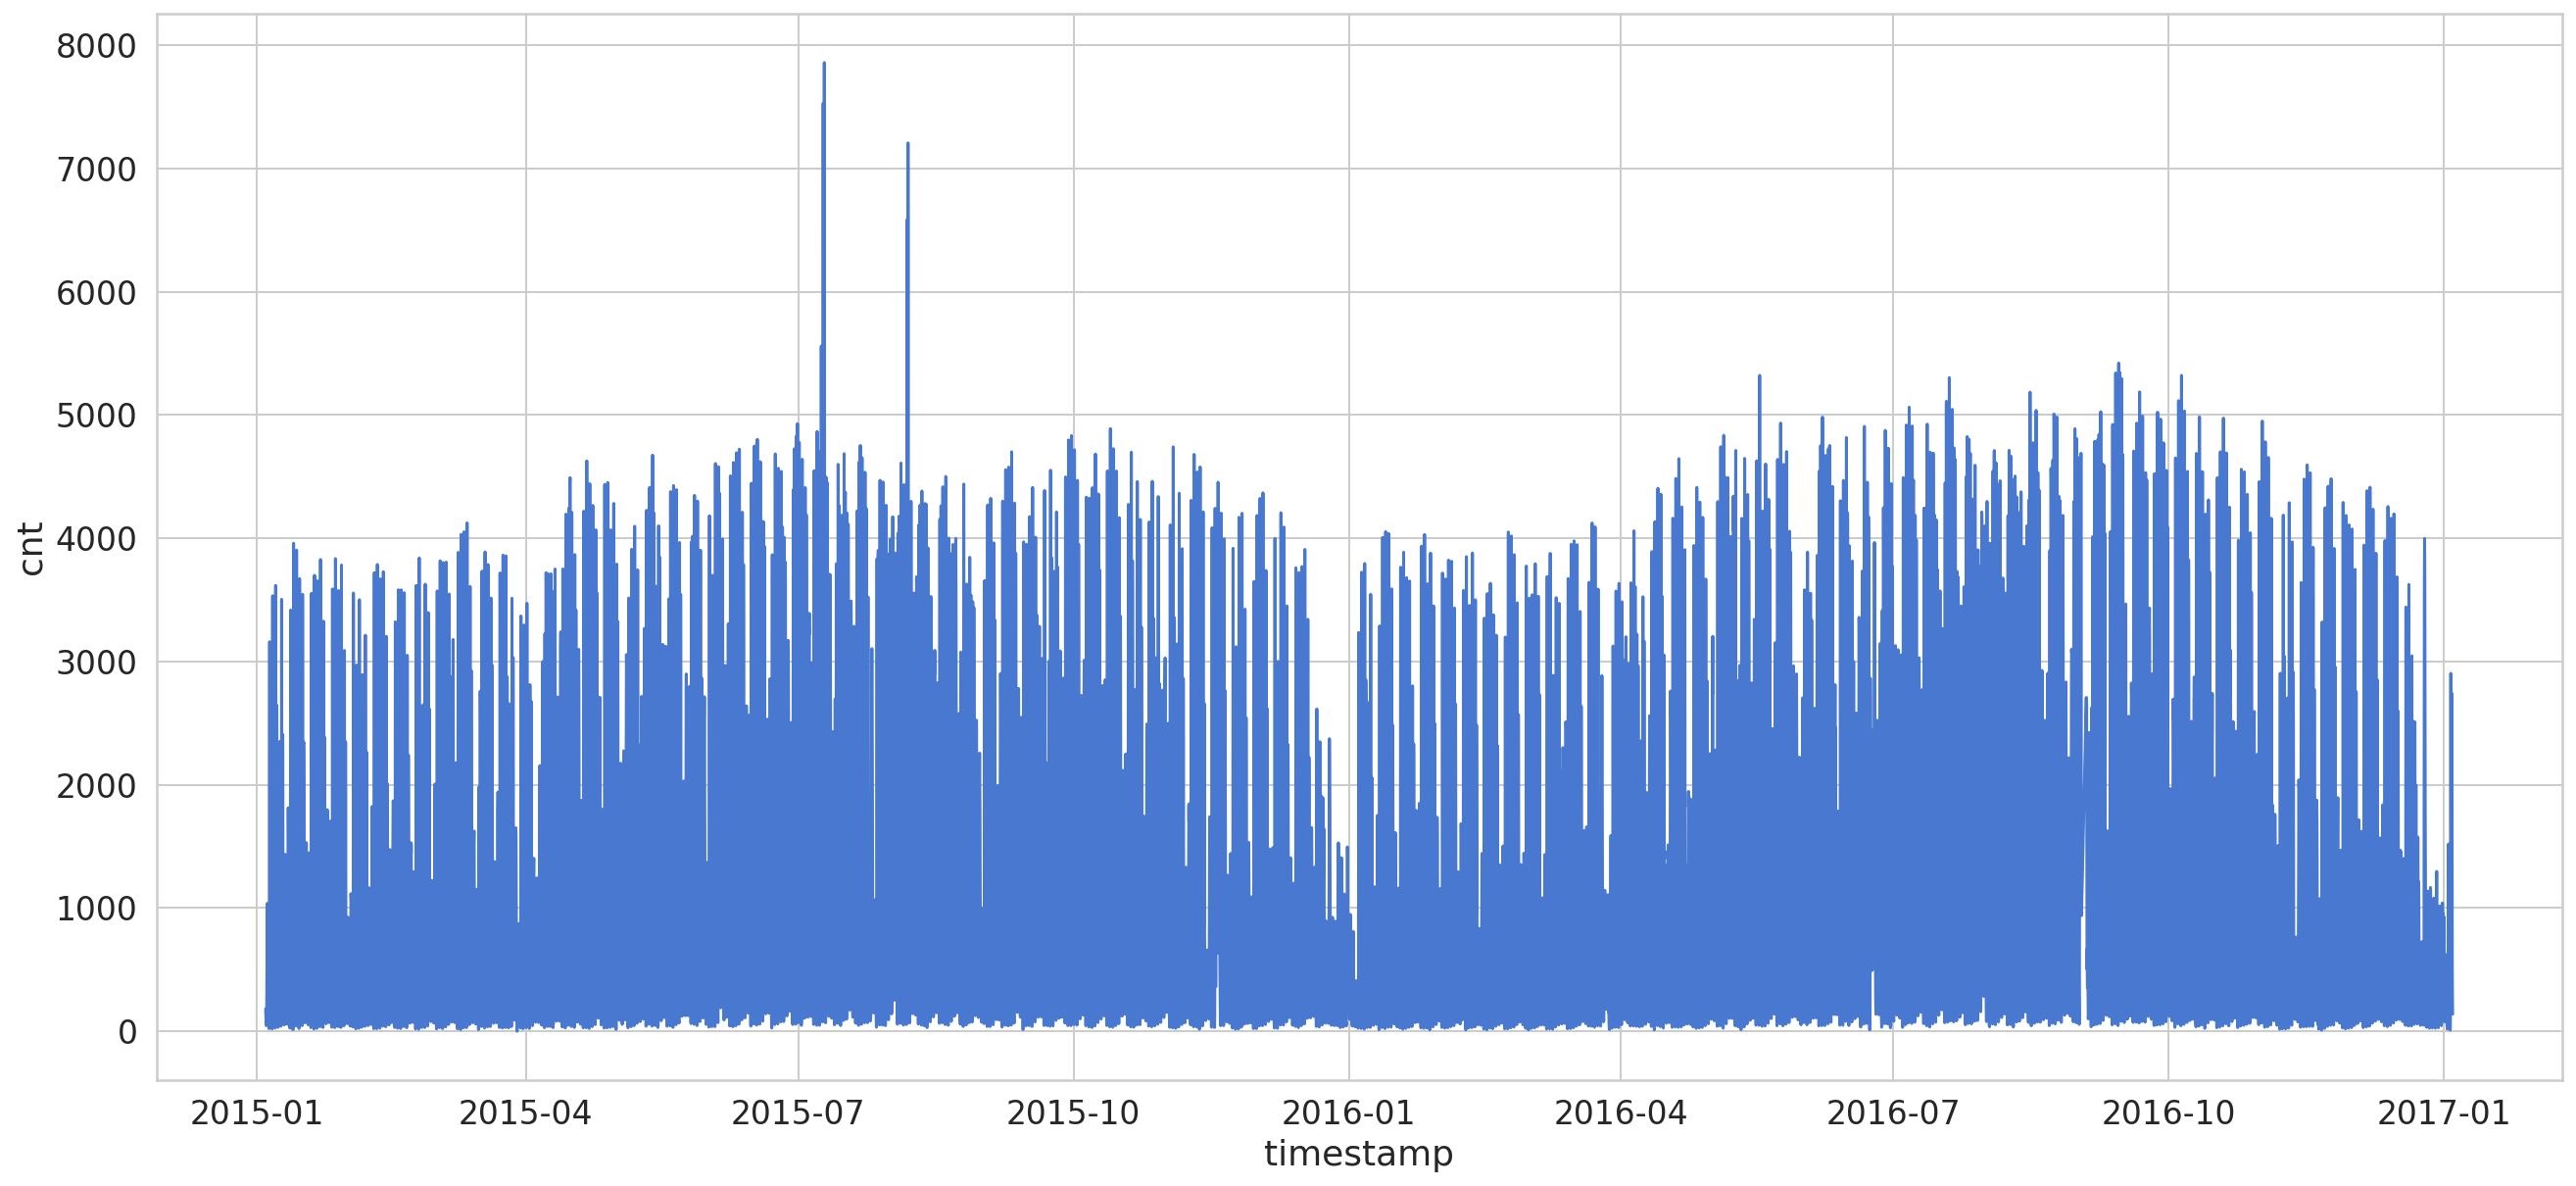

In [10]:
sns.lineplot(x=df.index, y="cnt", data=df);

Visualize by monthly sampling

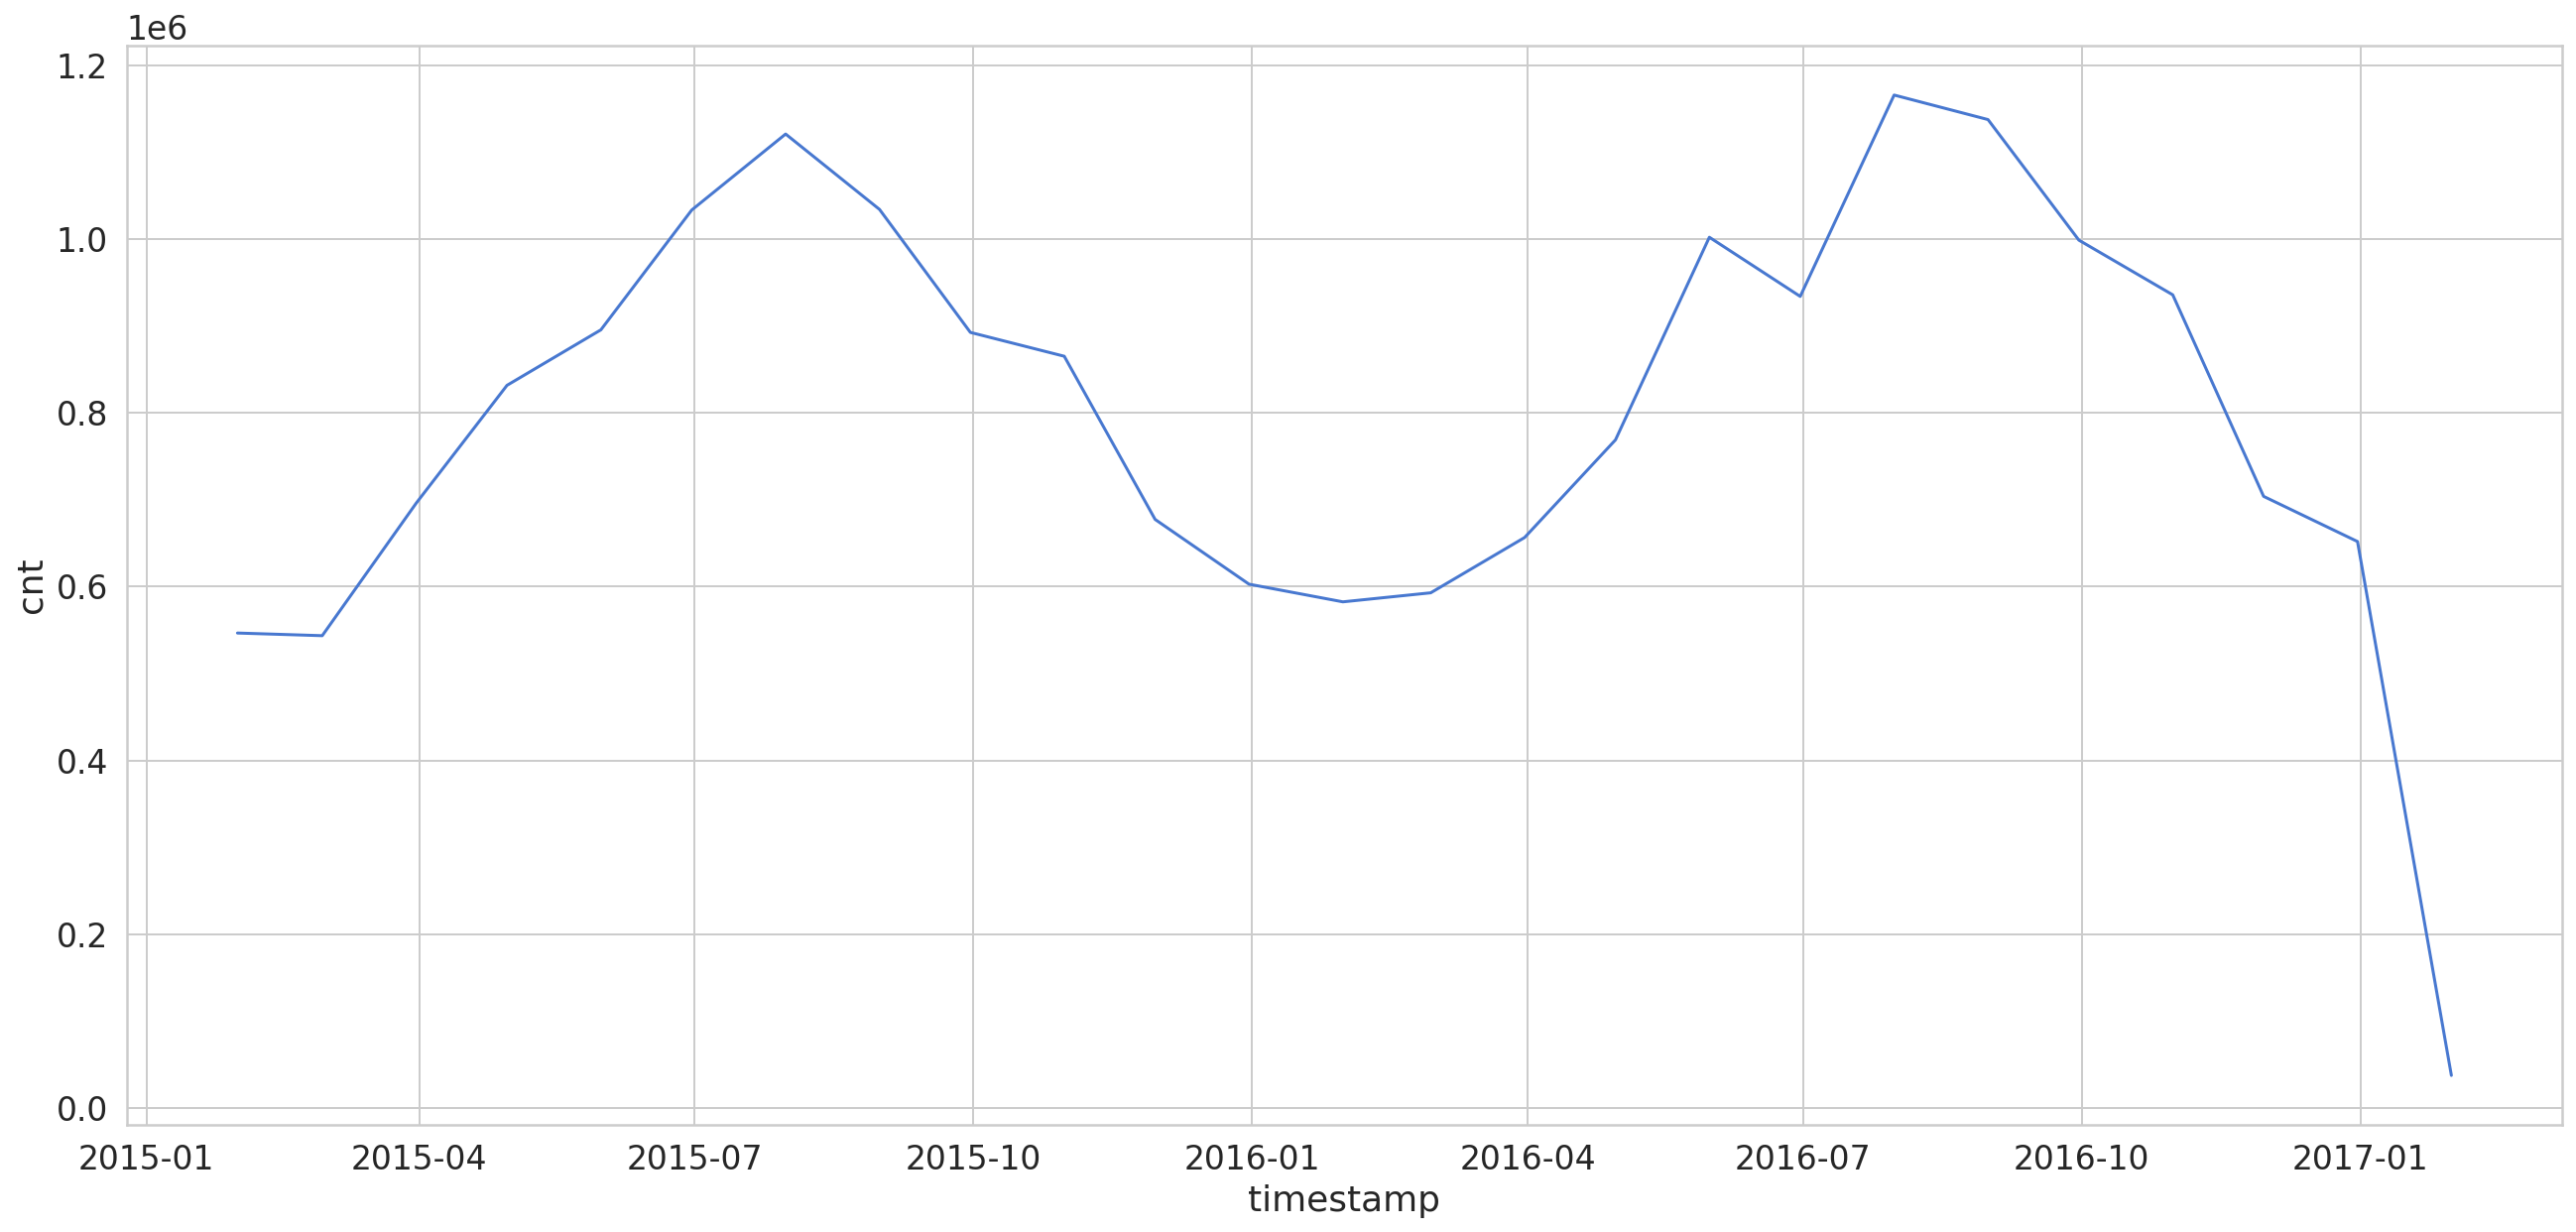

In [11]:
df_by_month = df.resample('M').sum()

sns.lineplot(x=df_by_month.index, y="cnt", data=df_by_month);

Visualize rented bikes by different time of the day.

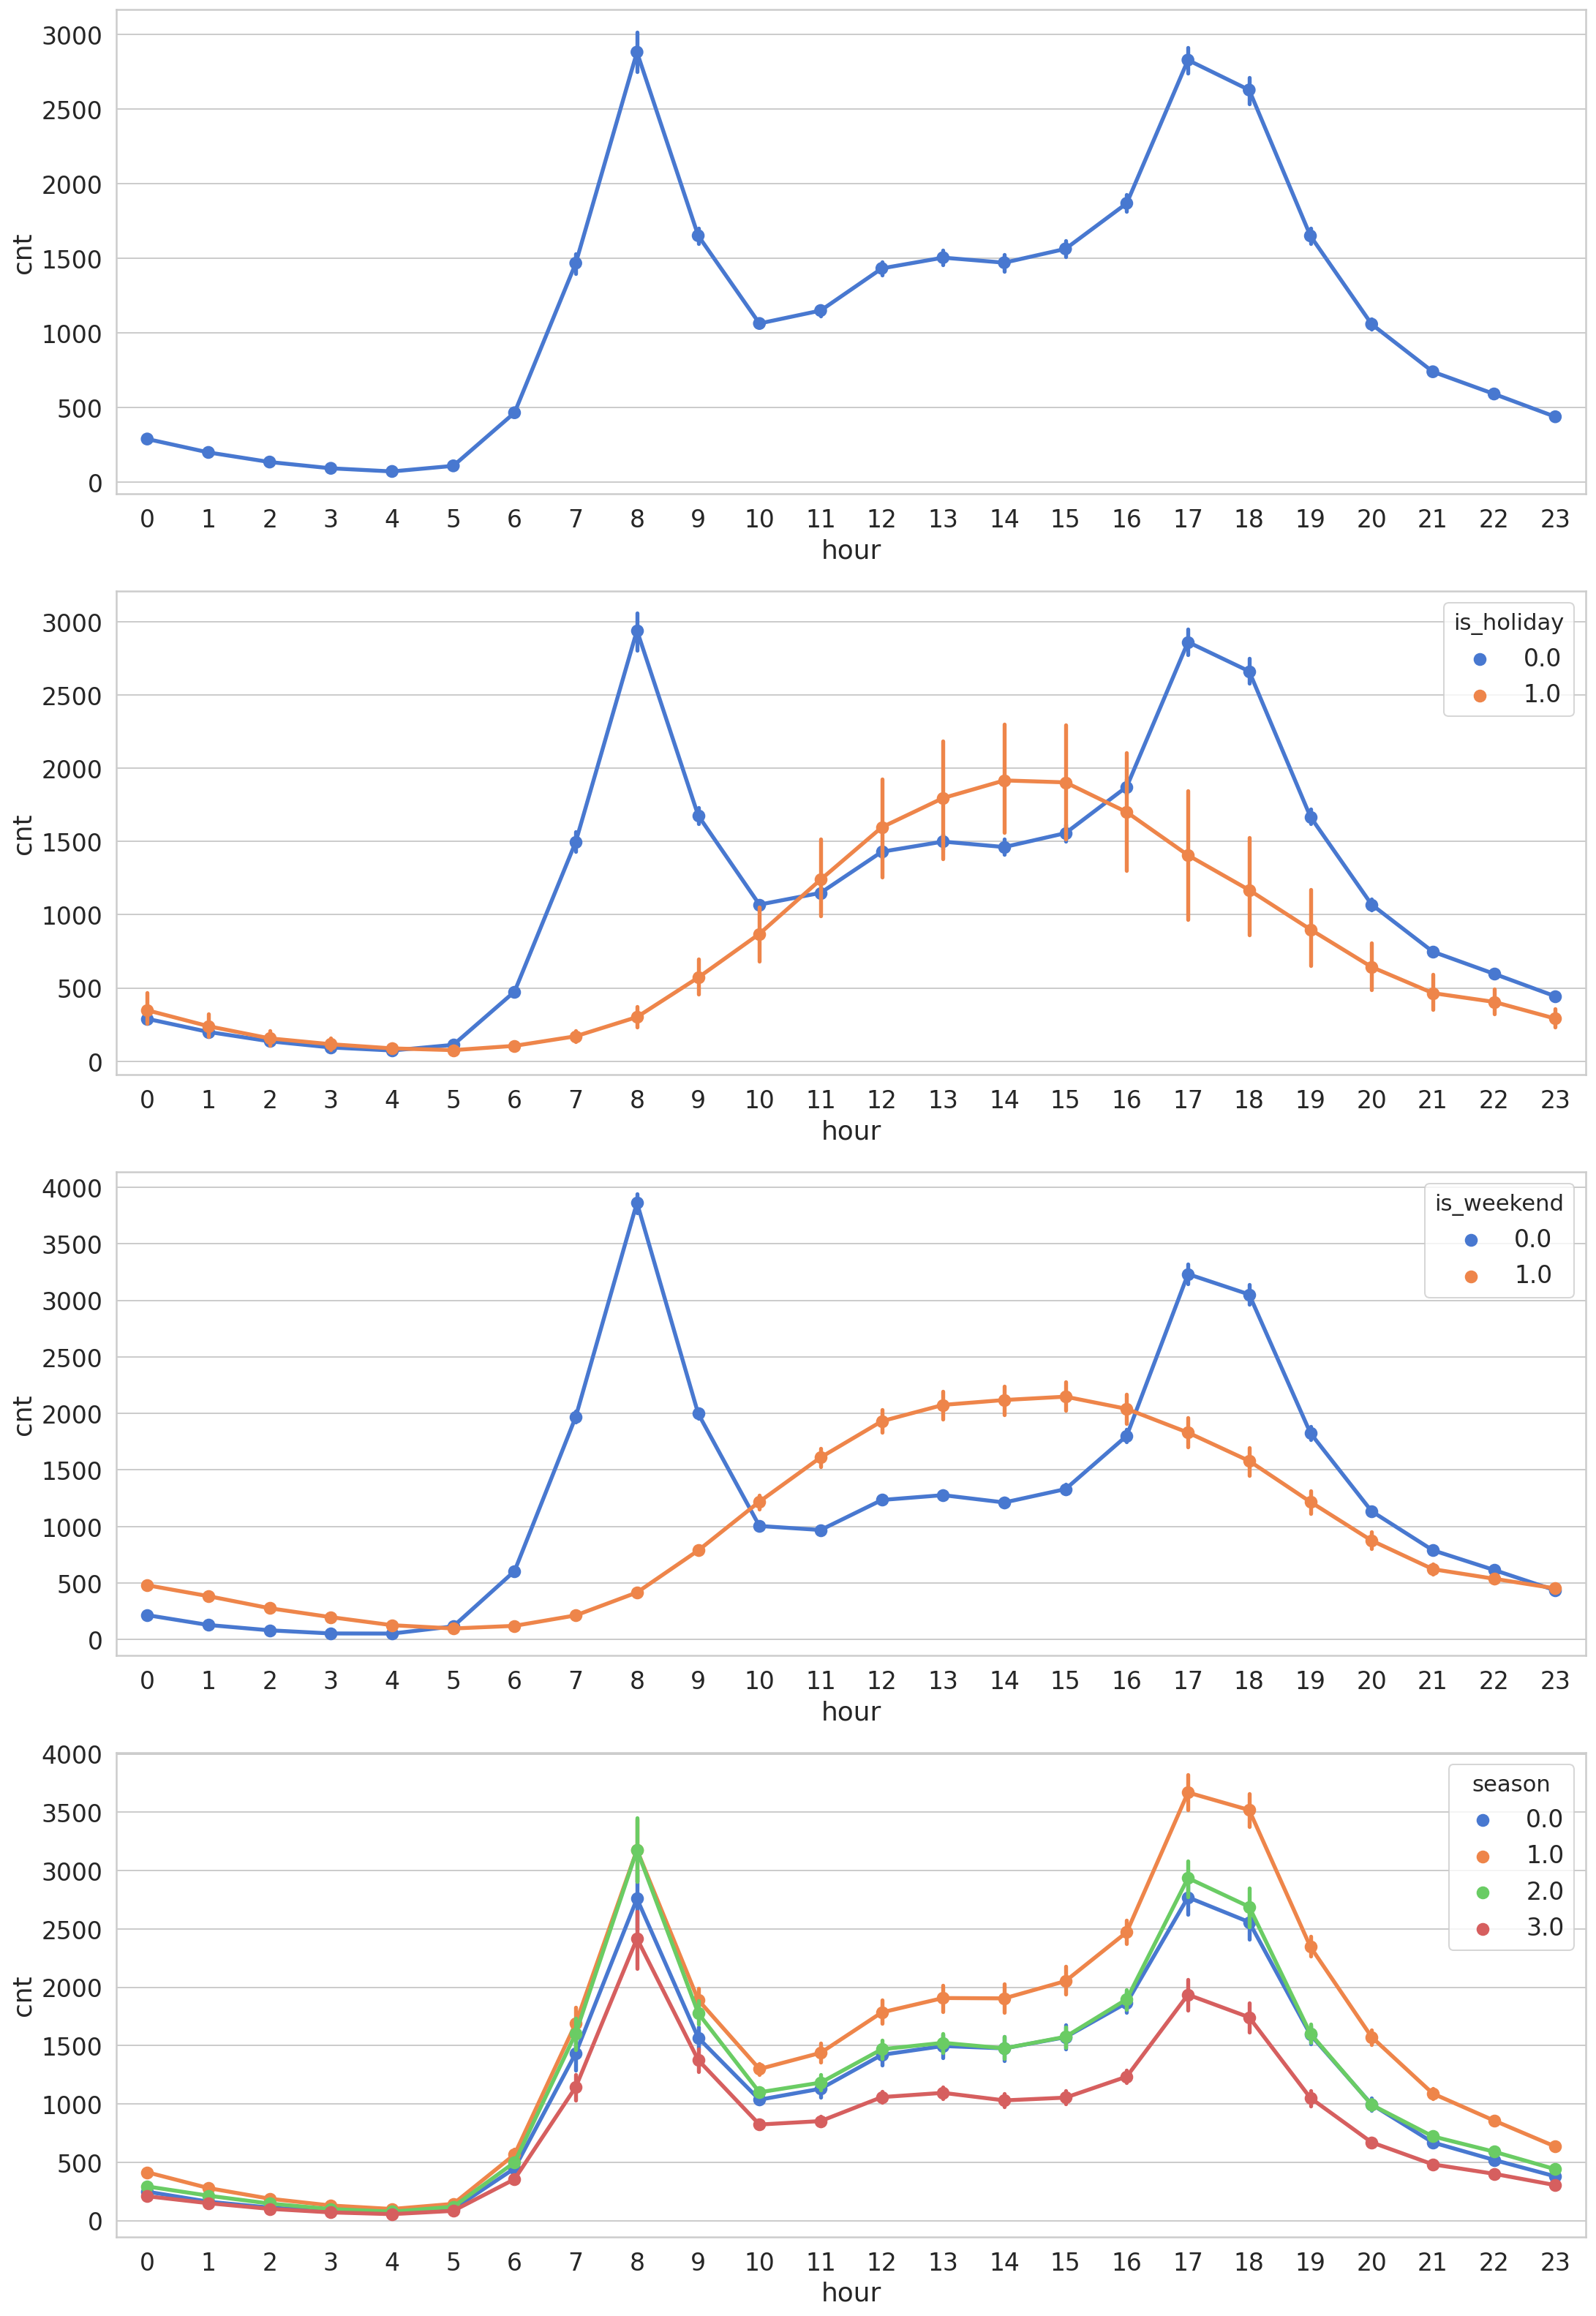

In [12]:
fig,(ax1, ax2, ax3, ax4)= plt.subplots(nrows=4)
fig.set_size_inches(18, 28)

sns.pointplot(data=df, x='hour', y='cnt', ax=ax1)


Visualize the number of rented bikes for each day of the week

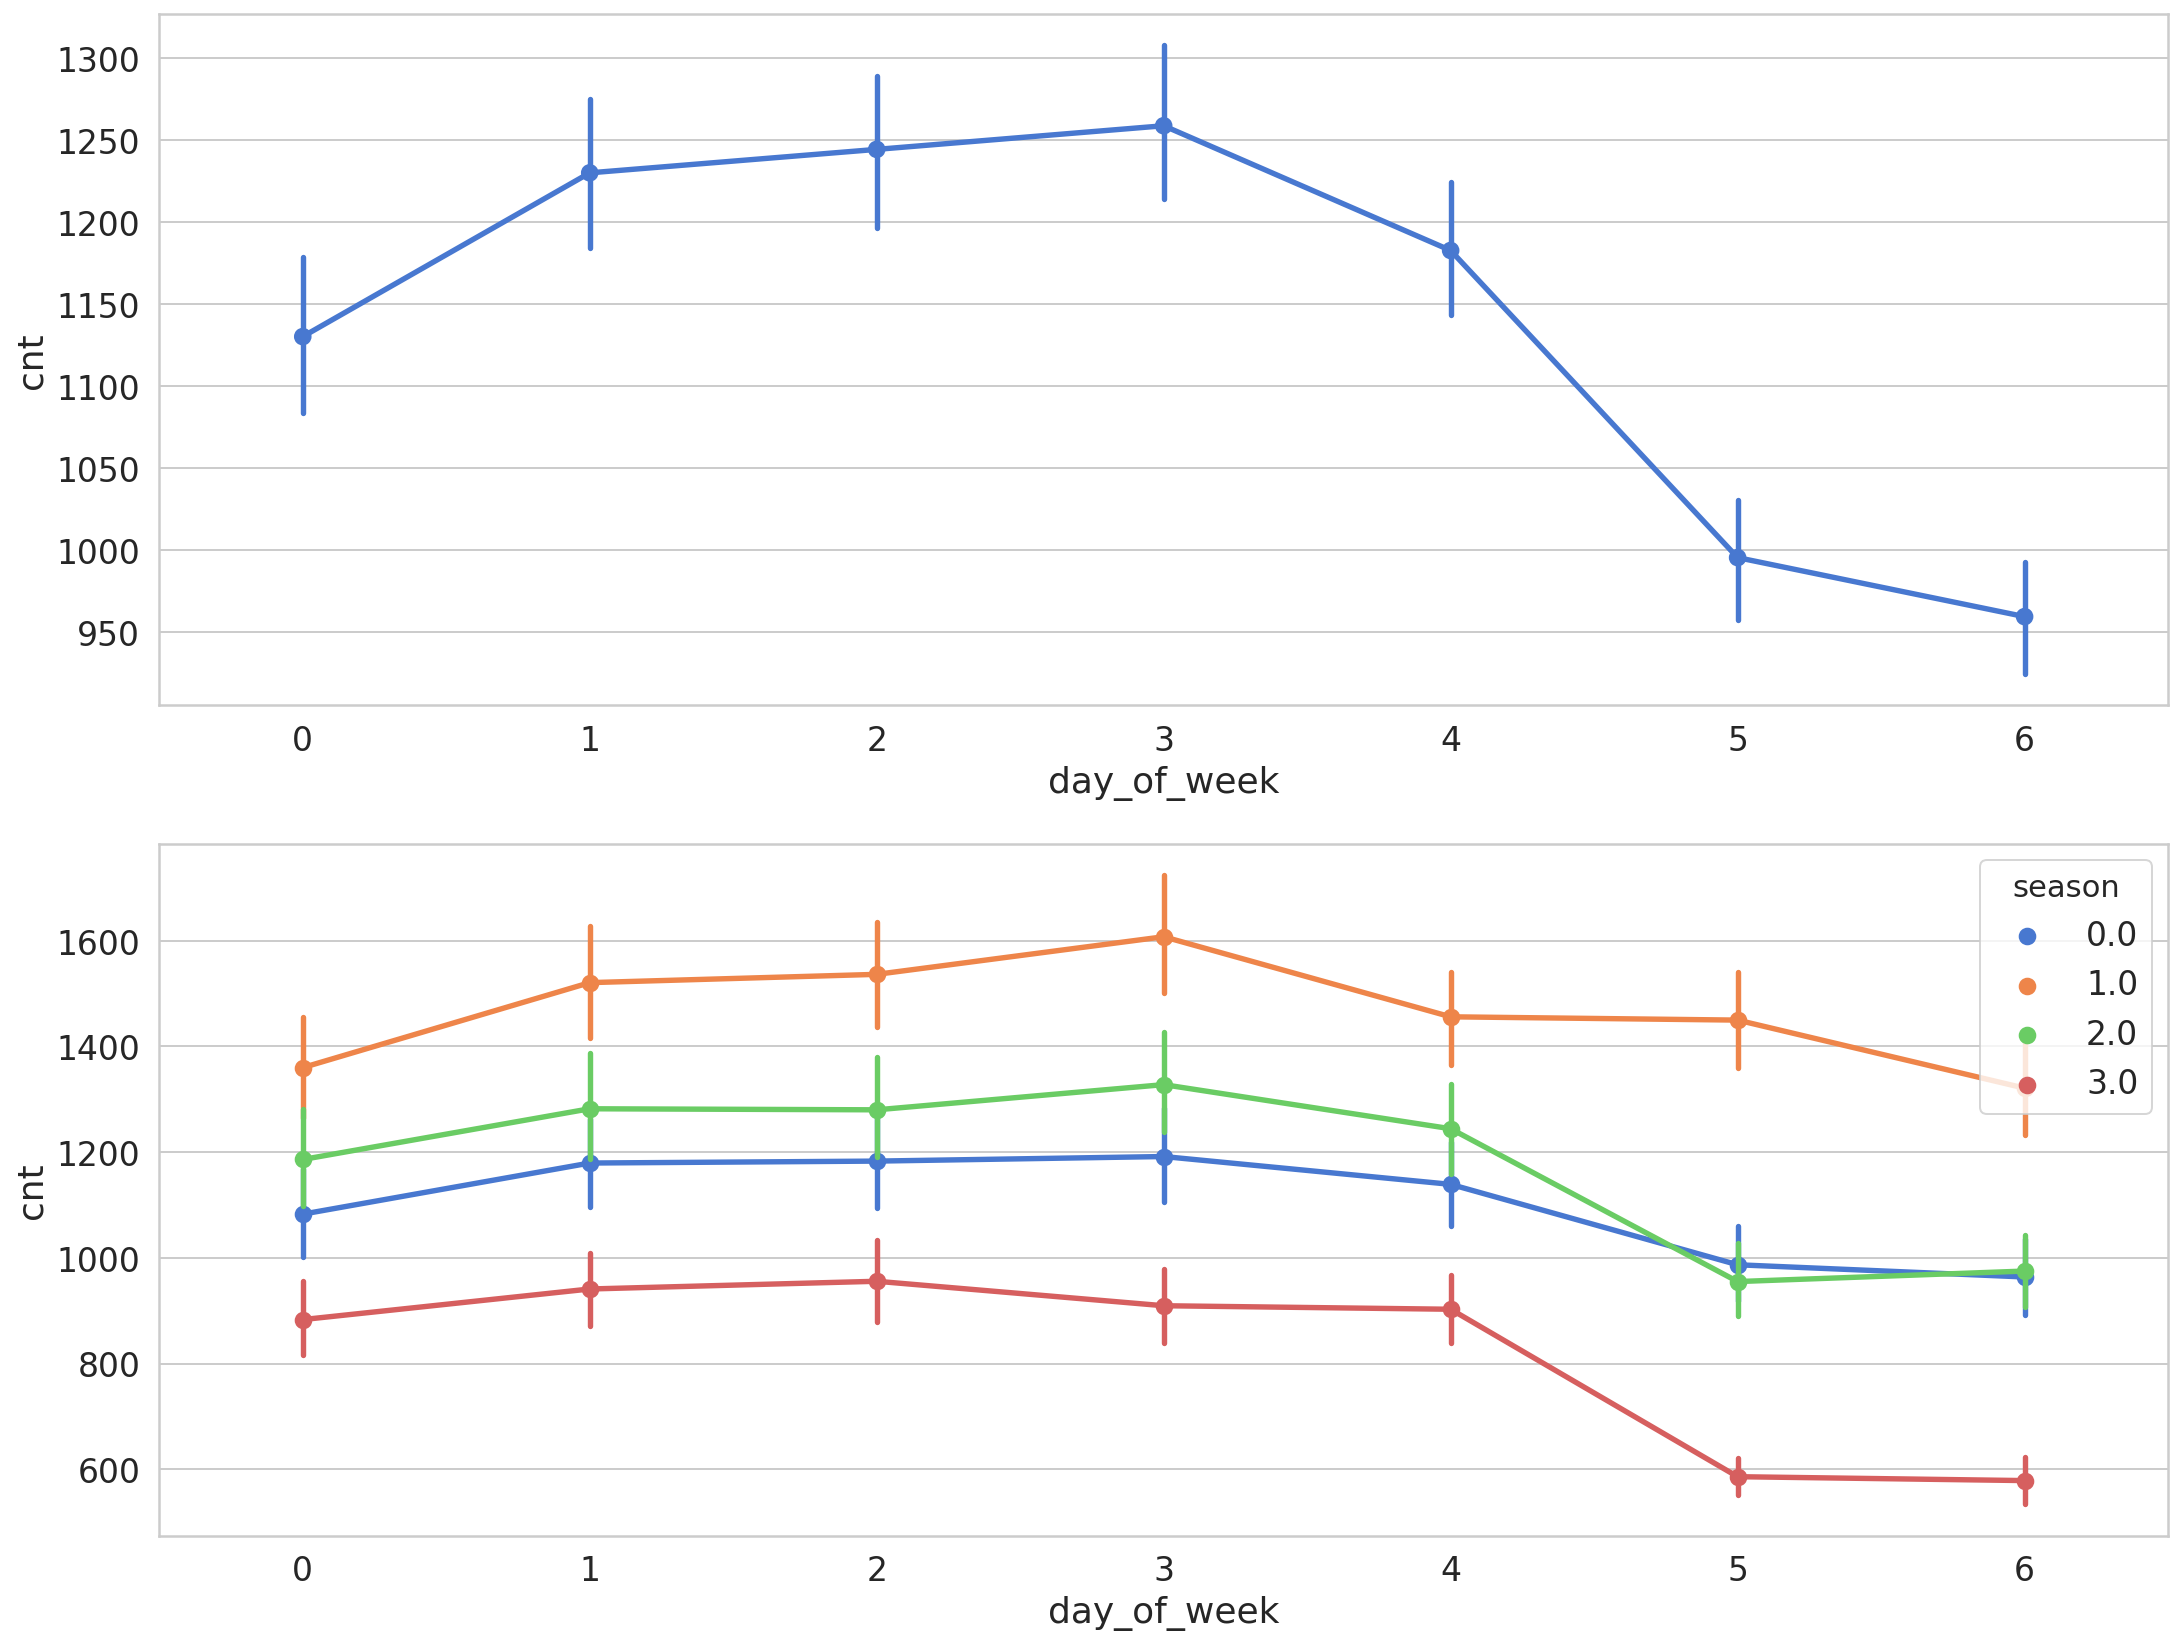

In [18]:
fig,(ax1, ax2)= plt.subplots(nrows=2)
fig.set_size_inches(18, 14)

sns.pointplot(data=df, x='day_of_week', y='cnt', ax=ax1)
sns.pointplot(data=df, x='day_of_week', y='cnt', hue='season', ax=ax2);

Create train+ test data

In [24]:
train_size = int(len(df) * 0.9)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size].copy(), df.iloc[train_size:len(df)].copy()
print(len(train), len(test))

15672 1742


Scaling data

In [0]:
from sklearn.preprocessing import RobustScaler

cols = ['t1', 't2', 'hum', 'wind_speed']

f_scale = RobustScaler()
cnt_transformer = RobustScaler()

train.loc[:, cols] = f_scale.fit(train[cols].to_numpy()).transform(train[cols].to_numpy())
train.loc[:,'cnt'] = f_scale.fit(train[['cnt']]).transform(train[['cnt']])

test.loc[:, cols] = f_scale.transform(test[cols].to_numpy())
test.loc[:,'cnt'] = f_scale.transform(test[['cnt']])

Define function to create a new data for LSTM model

In [0]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

Re_create train, test set

In [27]:
time_steps = 10

# reshape to [samples, time_steps, n_features]

X_train, y_train = create_dataset(train, train.cnt, time_steps)
X_test, y_test = create_dataset(test, test.cnt, time_steps)

print(X_train.shape, y_train.shape)

(15662, 10, 13) (15662,)


Create model

In [0]:
model = keras.Sequential()
model.add(
  keras.layers.Bidirectional(
    keras.layers.LSTM(units=128, input_shape=(X_train.shape[1], X_train.shape[2])
    )
  )
)
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(units=1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [29]:
history = model.fit(
    X_train, y_train, 
    epochs=30, 
    batch_size=32, 
    validation_split=0.1,
    shuffle=False
)

Train on 14095 samples, validate on 1567 samples
Epoch 1/30
14095/14095 [==============================] - 16s 1ms/sample - loss: 0.3126 - val_loss: 0.1138
Epoch 2/30
14095/14095 [==============================] - 13s 920us/sample - loss: 0.0832 - val_loss: 0.0526
Epoch 3/30
14095/14095 [==============================] - 13s 908us/sample - loss: 0.0506 - val_loss: 0.0494
Epoch 4/30
14095/14095 [==============================] - 13s 916us/sample - loss: 0.0384 - val_loss: 0.0389
Epoch 5/30
14095/14095 [==============================] - 13s 909us/sample - loss: 0.0318 - val_loss: 0.0319
Epoch 6/30
14095/14095 [==============================] - 13s 922us/sample - loss: 0.0290 - val_loss: 0.0322
Epoch 7/30
14095/14095 [==============================] - 13s 923us/sample - loss: 0.0260 - val_loss: 0.0368
Epoch 8/30
14095/14095 [==============================] - 13s 890us/sample - loss: 0.0239 - val_loss: 0.0373
Epoch 9/30
14095/14095 [==============================] - 13s 902us/sample - loss

Visualize model on train vs test 

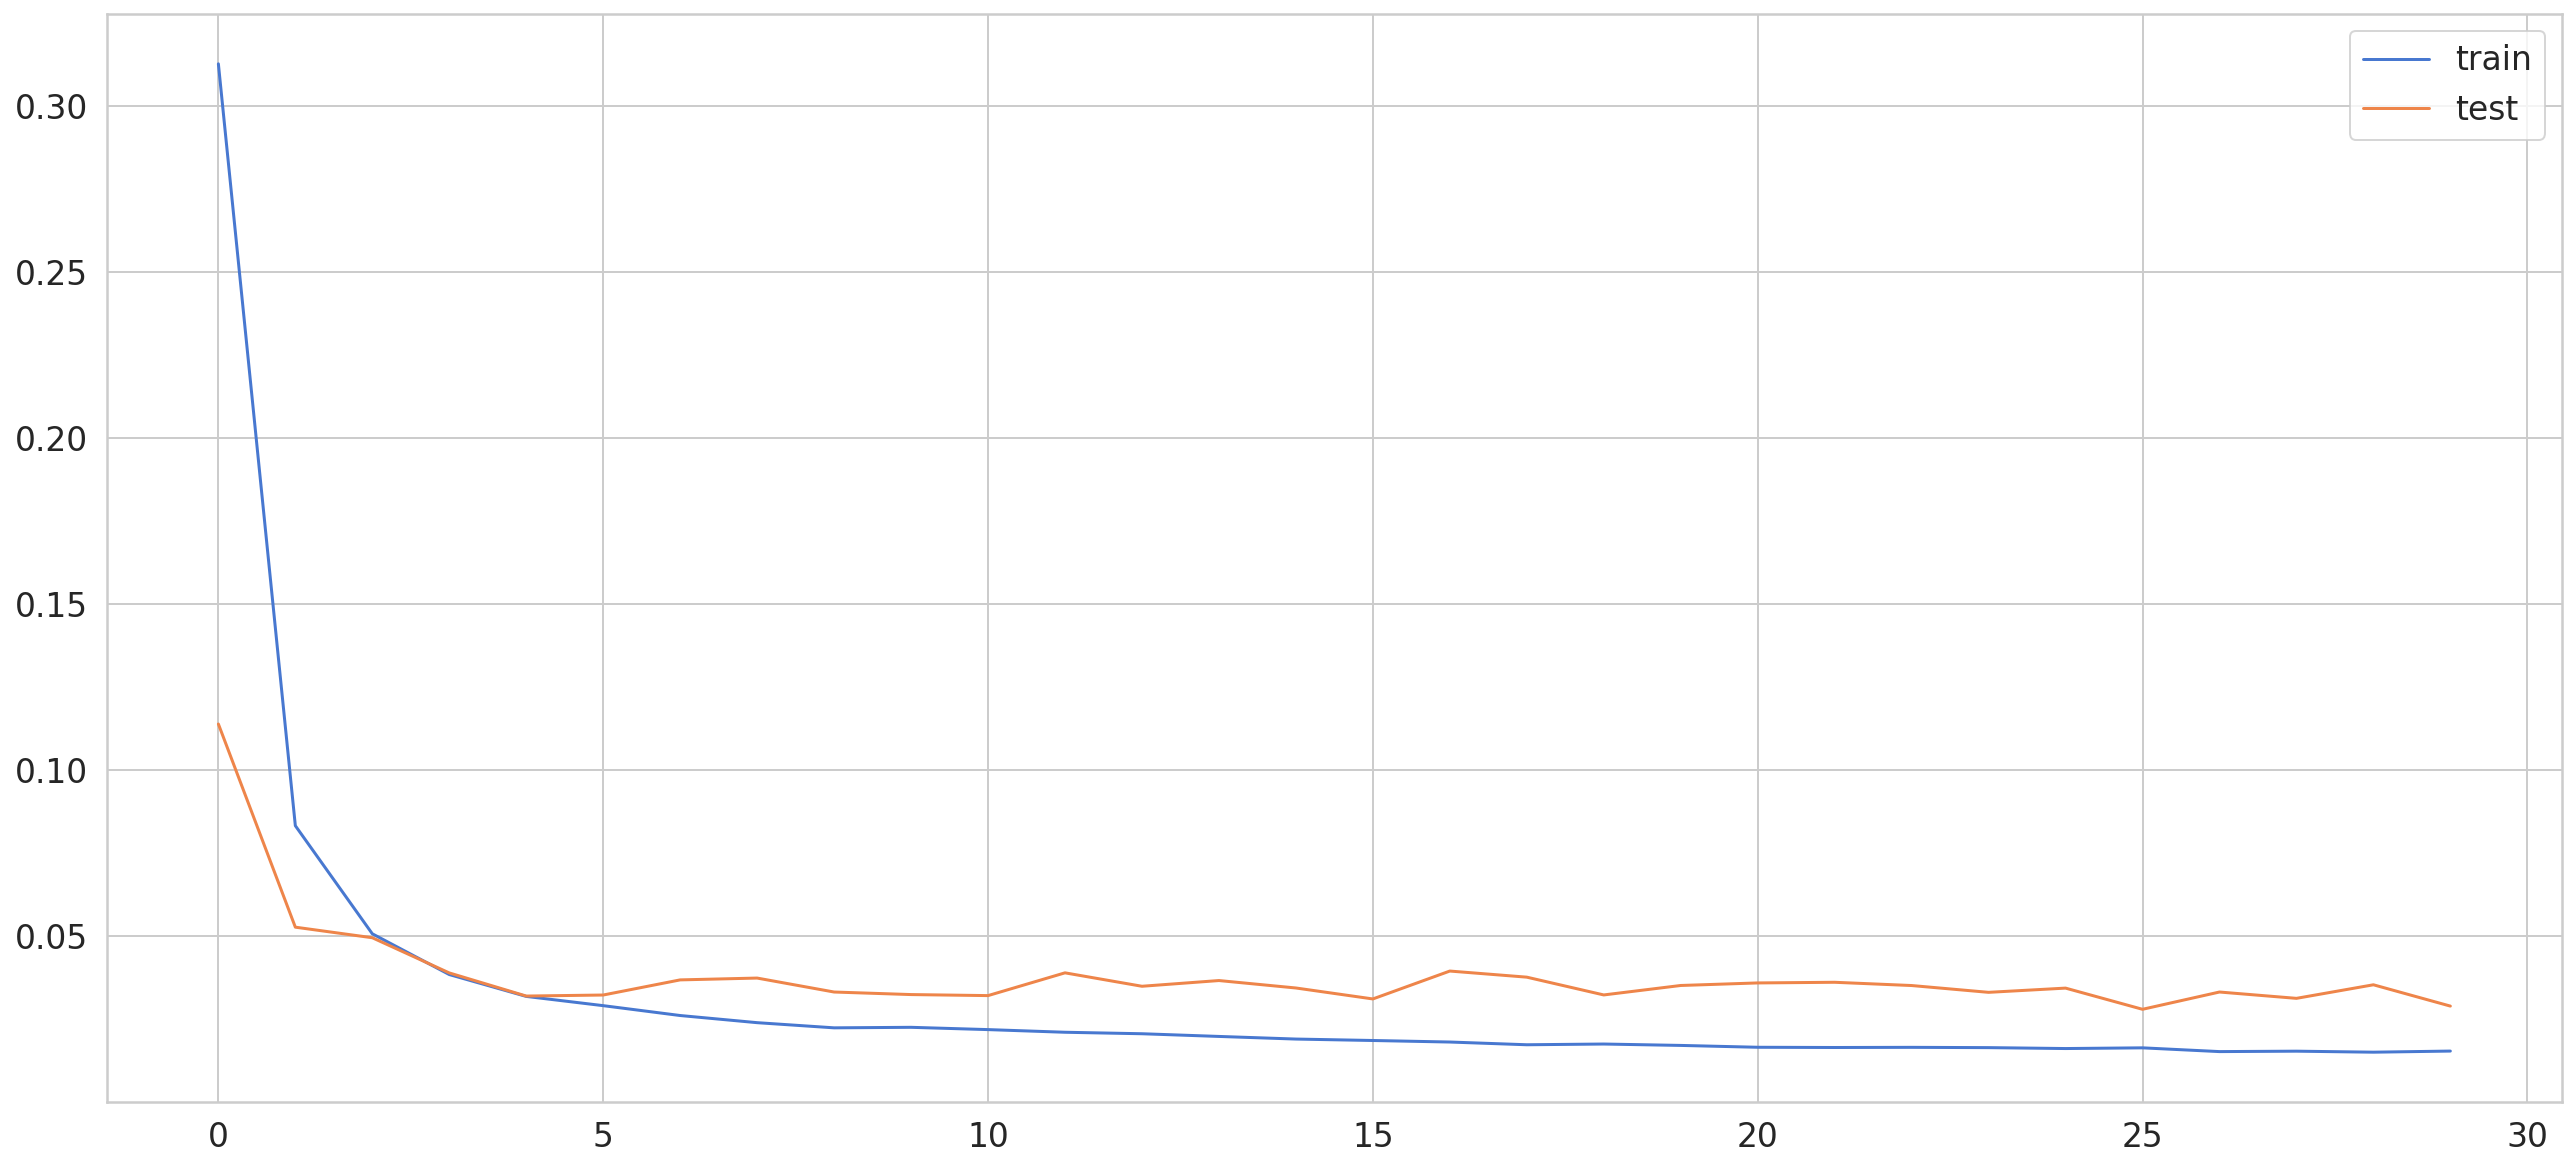

In [30]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

Predict on test set

In [31]:
y_pred = model.predict(X_test)
y_pred

array([[ 0.47211182],
       [ 0.1654671 ],
       [-0.0499597 ],
       ...,
       [-0.2269383 ],
       [-0.35922396],
       [-0.45270973]], dtype=float32)

Let un_scale back to the original scale

In [0]:
y_train_inv = f_scale.inverse_transform(y_train.reshape(1, -1))
y_test_inv = f_scale.inverse_transform(y_test.reshape(1, -1))
y_pred_inv = f_scale.inverse_transform(y_pred)

Visualize the prediction

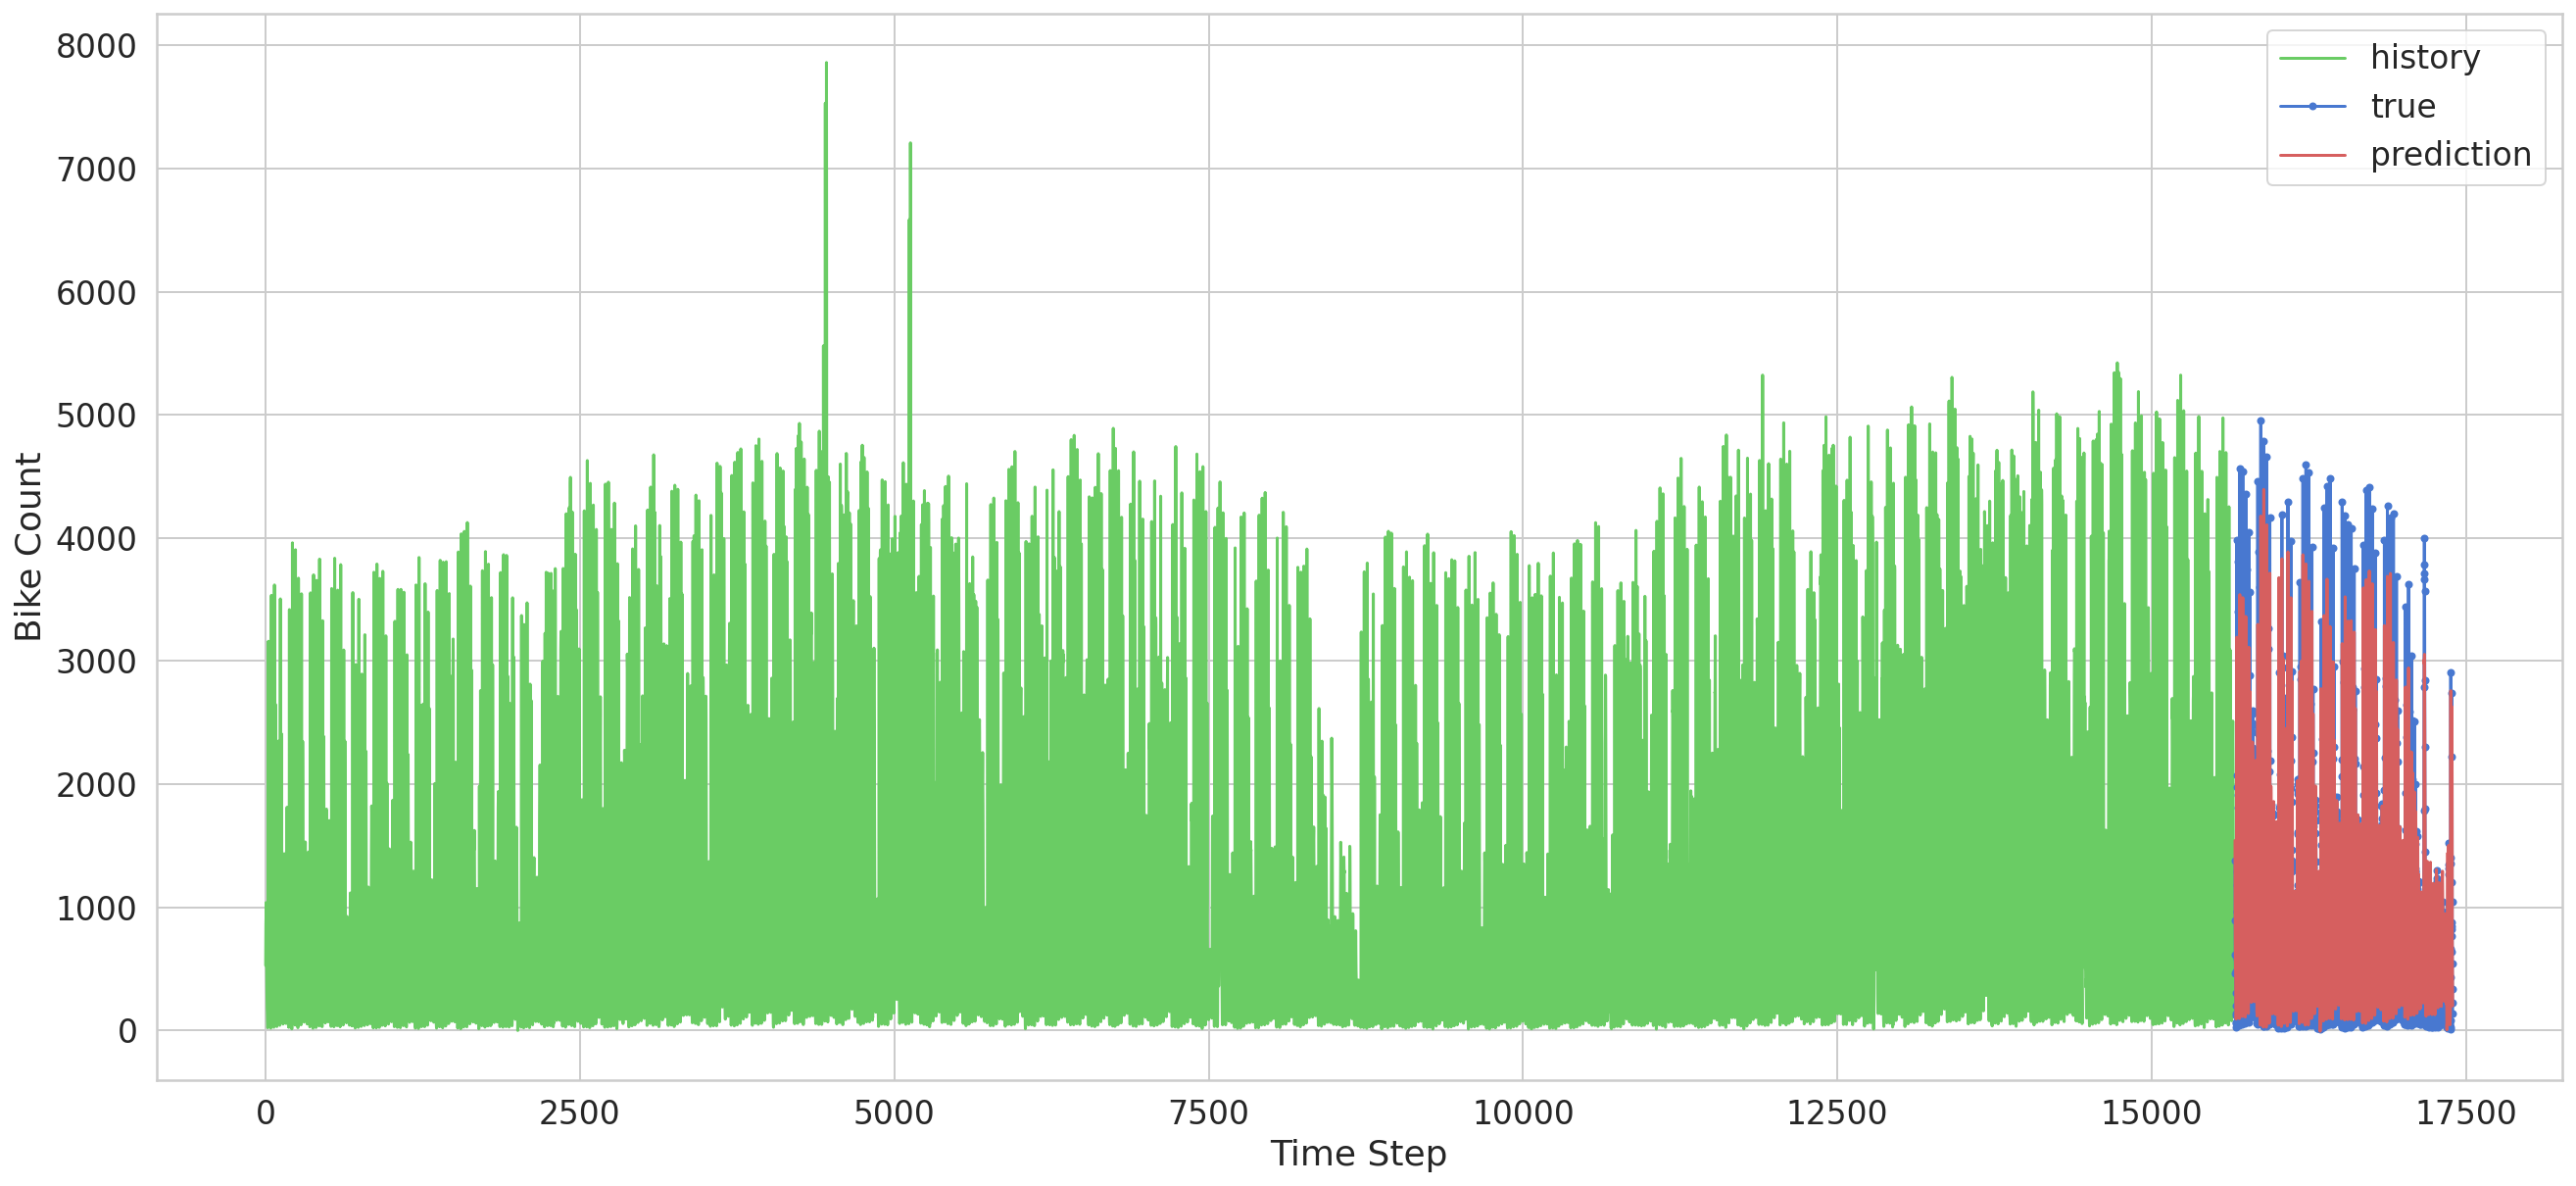

In [33]:
plt.plot(np.arange(0, len(y_train)), y_train_inv.flatten(), 'g', label="history")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test_inv.flatten(), marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred_inv.flatten(), 'r', label="prediction")
plt.ylabel('Bike Count')
plt.xlabel('Time Step')
plt.legend()
plt.show();

Visualize prediction vs true 

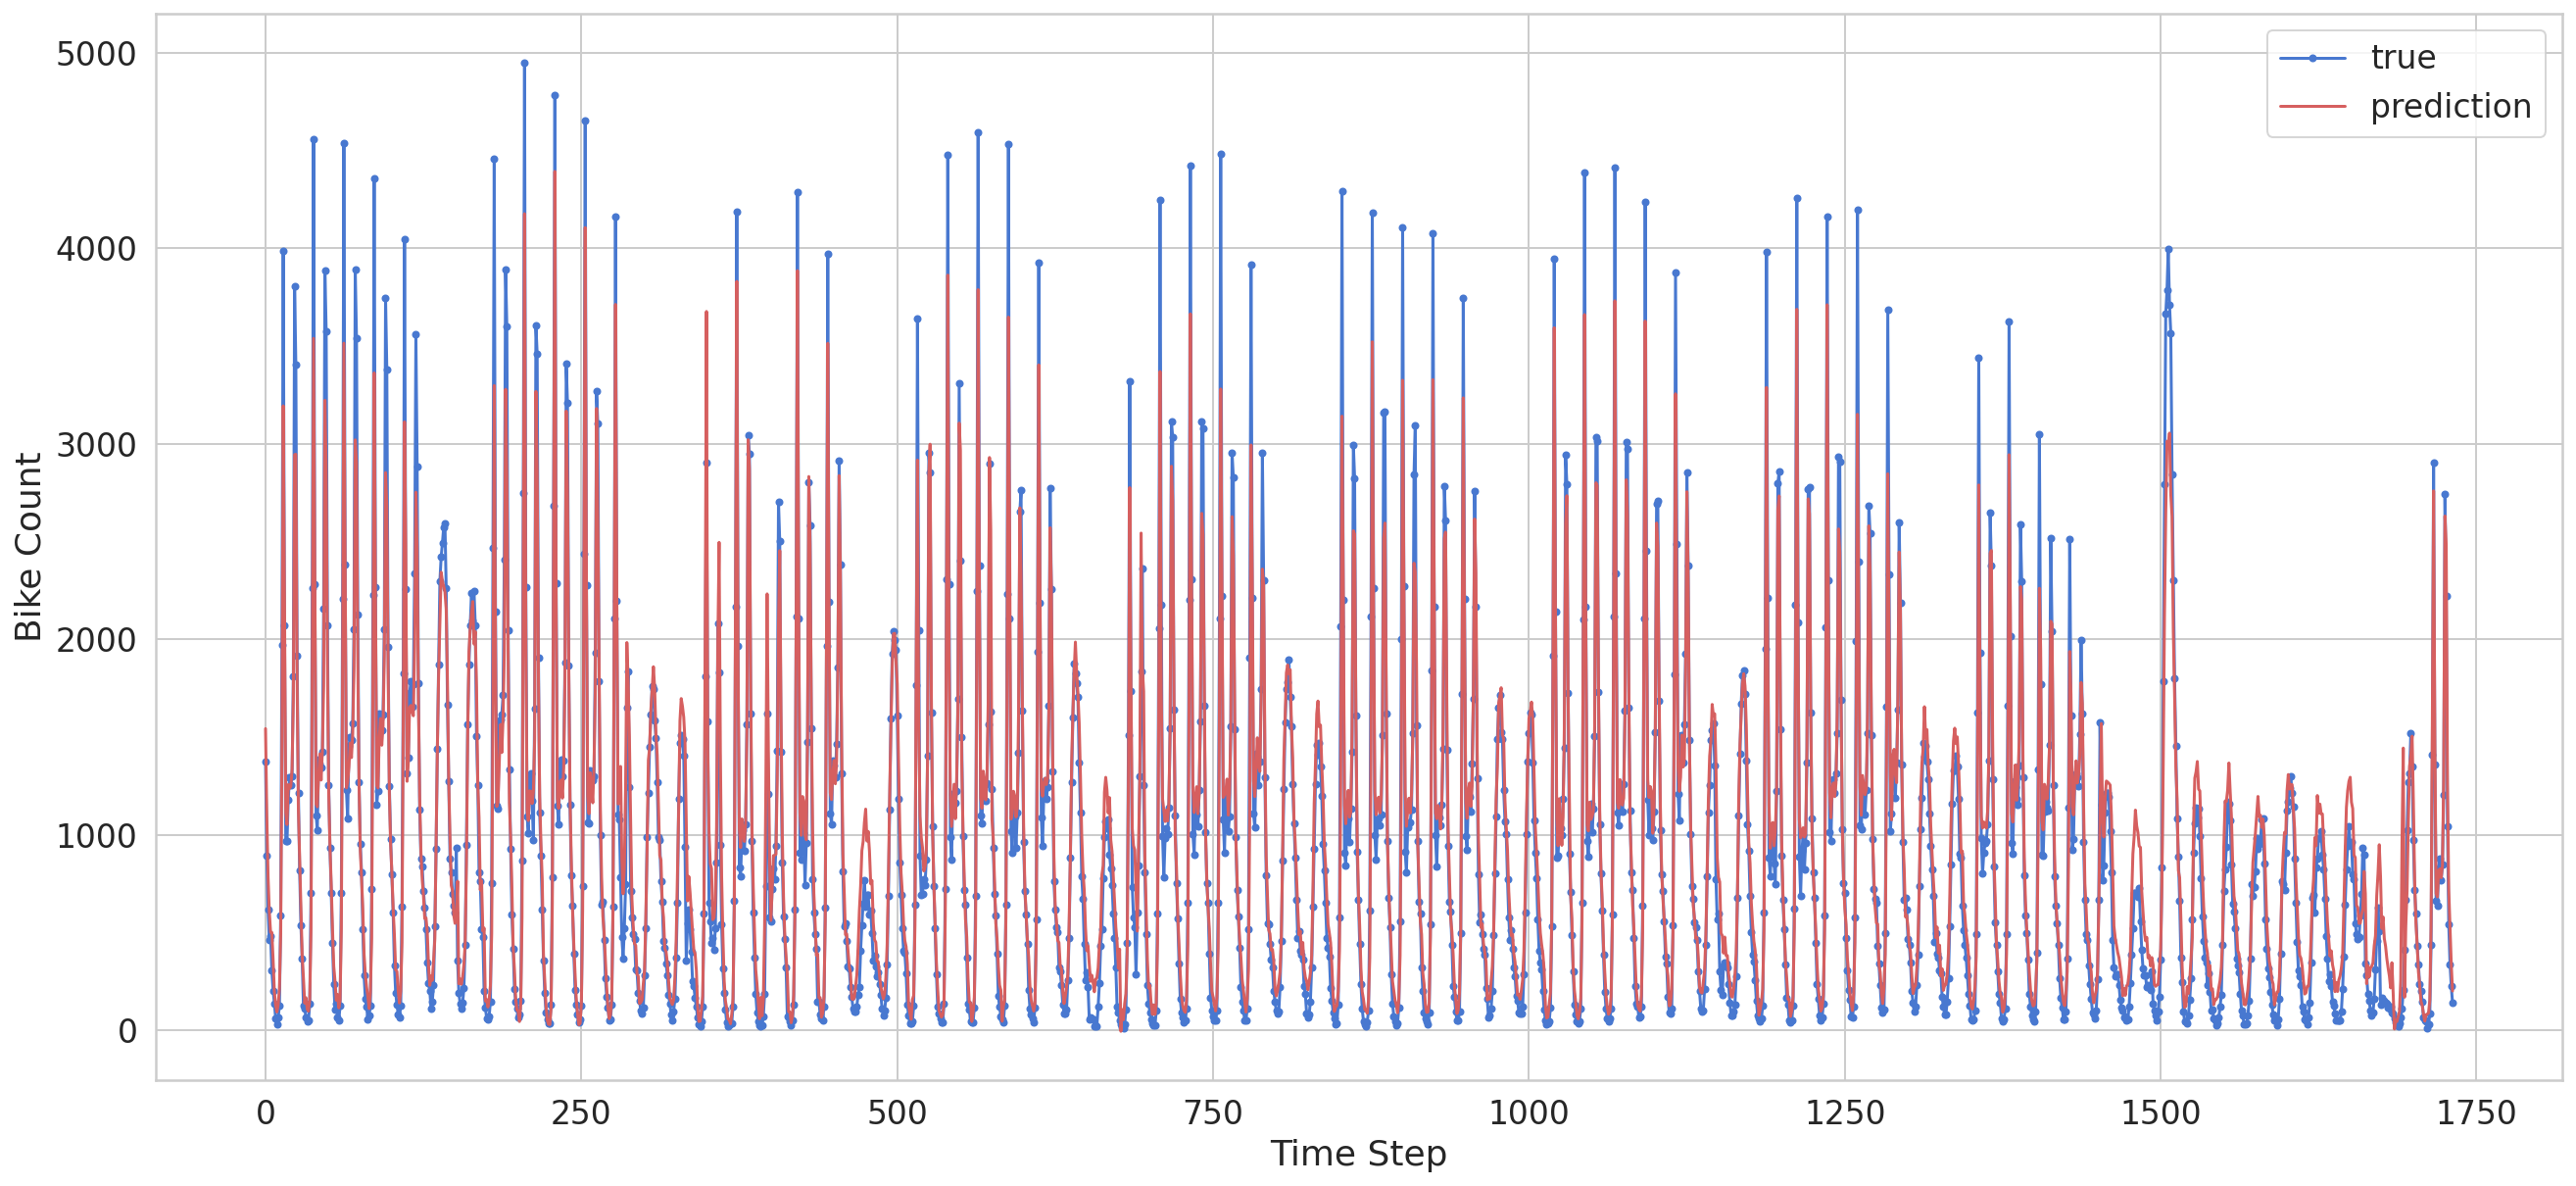

In [34]:
plt.plot(y_test_inv.flatten(), marker='.', label="true")
plt.plot(y_pred_inv.flatten(), 'r', label="prediction")
plt.ylabel('Bike Count')
plt.xlabel('Time Step')
plt.legend()
plt.show();